In [1]:
# https://www.kaggle.com/code/awadhi123/intel-multiclass-classification/notebook
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         continue
#         #print(os.path.join(dirname, filename))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import os
import pathlib
import jovian
import torch
import tarfile
import torchvision
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url

<IPython.core.display.Javascript object>

In [3]:
# Transformation function that will transform images
transform_train = transforms.Compose([
    
    transforms.Resize((150,150)), #becasue vgg takes 150*150
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    
])

#Augmentation is not done for test/validation data.
transform_test = transforms.Compose([
    
    transforms.Resize((150,150)), #becasue vgg takes 150*150
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    
])

In [4]:
# Create dataset from Image Folder
train_ds = ImageFolder('input/seg_train', transform=transform_train)
test_ds = ImageFolder('input/seg_test', transform=transform_test)
# pred_ds = ImageFolder('input/seg_pred/', transform=transform_test) # todo
# type(test_ds) # todo

# How many images are present in train,test, pred folder
print(f"Number of images in train: {len(train_ds)}, test: {len(test_ds)}.")

# what is size of image?
image, label  = train_ds[0]
print(" what is size of image?", image.shape, label)

# Create a dataloader that loads data in batches
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)
# pred_dl = DataLoader(pred_ds, batch_size, num_workers=4, pin_memory=True) # todo

batch_size=128
train_dl2 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

Number of images in train: 14034, test: 3000.
 what is size of image? torch.Size([3, 150, 150]) 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 150, 150])


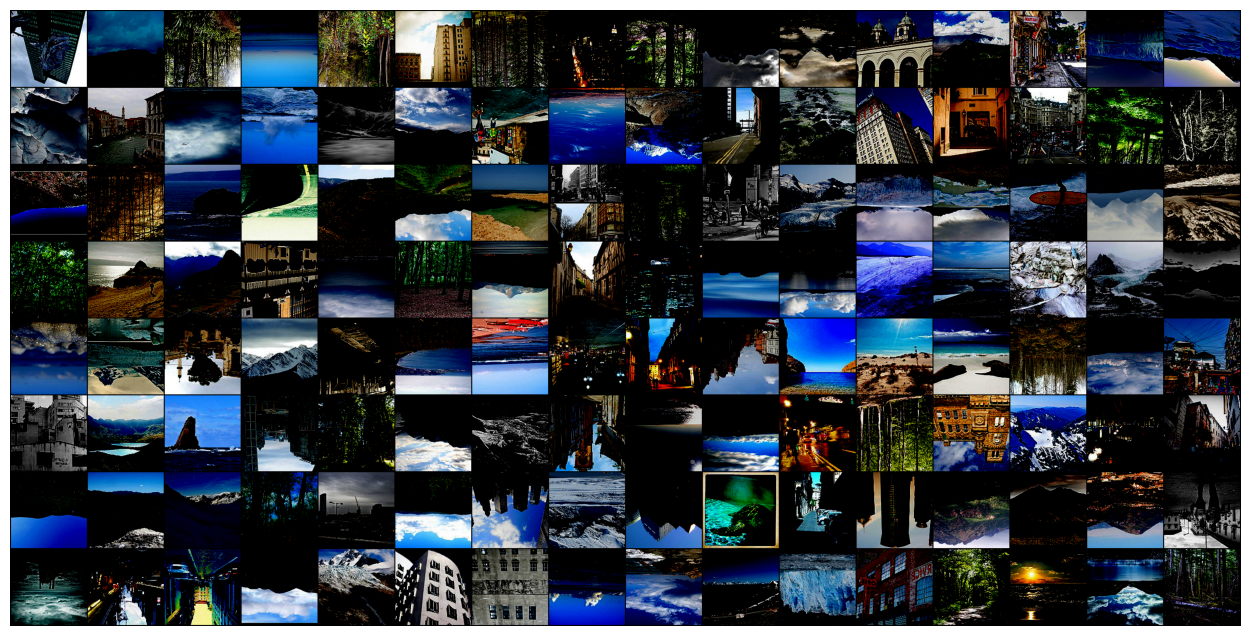

In [5]:
for images, _ in train_dl2:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
# Create classes with directory name
root = pathlib.Path('input/seg_train/')
classes = sorted([j.name.split(os.sep)[-1] for j in root.iterdir()])
print(classes)

# Create a function that can calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [8]:
# vgg ntework
from torchvision import models 
modelvgg = models.vgg19(weights = True)

# resnet
modelresnet50 = models.resnet50(weights = True)

# freeze all layers
for p in modelvgg.parameters() : 
    p.requires_grad = False

for q in modelresnet50.parameters() :
    q.requires_grad = False

In [9]:
# add your own classifier according to need
modelvgg.classifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=2048) ,
  nn.ReLU(),
  nn.Linear(in_features=2048, out_features=512) ,
  nn.ReLU(),
  nn.Dropout(p=0.6),
  nn.Linear(in_features=512 , out_features=6),
  nn.LogSoftmax(dim=1)  
)

modelresnet50.fc = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024) ,
  nn.ReLU(),
  nn.Linear(in_features=1024, out_features=512) ,
  nn.ReLU(),
  nn.Dropout(p=0.6), 
  nn.Linear(in_features=512 , out_features=6),
  nn.LogSoftmax(dim=1)  
)

print(modelresnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# Create a base class for image classificaiton
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
## create an inherited class form above base class that will be our first model architecture
# class IntelCnnModel(ImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

#             nn.Flatten(), 
#             nn.Linear(256*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 6))
        
#     def forward(self, xb):
#         return self.network(xb)

In [11]:
class IntelCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = modelvgg
        
    def forward(self, xb):
        return self.network(xb)

class IntelCnnModelresnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = modelresnet50
        
    def forward(self, xb):
        return self.network(xb)
    
model = IntelCnnModel()
model2 = IntelCnnModelresnet()

In [12]:
# Get the default device and select GPU if available else select cpu
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Define a Function that can move tensors and model to specific device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Wrap a dataloader to move data to a device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
# Get currently using device name
device = get_default_device()
print(device)

# Call data loader and move tensor and model to device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
# pred_dl = DeviceDataLoader(pred_dl, device)
to_device(model, device)

cpu


IntelCnnModel(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [13]:
# Now define some functions that will be used during training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()   #eval() is called to tell model that now it is validation mode and so don't perform stuff like dropout,backpropagation etc..
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() #eval() is called to tell model that now it is training mode and so  perform stuff like dropout,backpropagation etc..
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
# First let move model to gpu and then evaluate model once before training
# model = to_device(IntelCnnModel(), device)
model = to_device(model, device)
evaluate(model, val_dl)

# model = to_device(IntelCnnModel(), device)
model2 = to_device(model2, device)
evaluate(model2, val_dl)

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.000001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

val = evaluate(model, val_dl)
print(val)

lrs = [.00001,.000001]
epochs = [10,5]
jovian.log_hyperparameters(arch = "cnn",lrs = lrs,epochs = epochs)
jovian.log_metrics(test_loss=val['val_loss'], test_acc=val['val_acc'])

In [ ]:
# Function that will plot accuracy graph
# def plot_accuracies(history):
#     accuracies = [x['val_acc'] for x in history]
    
#     plt.plot(accuracies, '-x')
#     plt.xlabel('epoch')
#     plt.ylabel('accuracy')
#     plt.title('Accuracy vs. No. of epochs')

# Function that will plot loss graph
# def plot_losses(history):
#     train_losses = [x.get('train_loss') for x in history]
#     val_losses = [x['val_loss'] for x in history]
#     plt.plot(train_losses, '-bx')
#     plt.plot(val_losses, '-rx')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.legend(['Training', 'Validation'])
#     plt.title('Loss vs. No. of epochs');

def predict_single(input,label, model):
    input = to_device(input,device)
    inputs = input.unsqueeze(0)   # unsqueeze the input i.e. add an additonal dimension
    predictions = model(inputs)
    prediction = predictions[0].detach().cpu()
    print(f"Prediction is {np.argmax(prediction)} of Model whereas given label is {label}")

models = [modelvgg, modelresnet50]